In [72]:
import numpy as np
import matplotlib.pyplot as plt

In [73]:
def load_data(path):
    def one_hot(y):
        table = np.zeros((y.shape[0], 10))
        for i in range(y.shape[0]):
            table[i][int(y[i][0])] = 1 
        return table

    def normalize(x): 
        x = x / 255
        return x 

    data = np.loadtxt('{}'.format(path), delimiter = ',')
    return normalize(data[:,1:]),one_hot(data[:,:1])

X_train, y_train = load_data('data/mnist_train.csv')
X_test, y_test = load_data('data/mnist_test.csv')

In [88]:
class NumpyNN:
    def __init__(self, X, y, batch = 64, lr = 1e-3,  epochs = 20):
        self.input = X 
        self.output = y
        self.batch = batch
        self.epochs = epochs
        self.lr = lr
        
        self.x = self.input[:self.batch]
        self.y = self.output[:self.batch]
        self.loss = []
        self.acc = []
        
        self.init_weights()
      
    def init_weights(self):
        self.W1 = np.random.randn(self.input.shape[1],256)
        self.W2 = np.random.randn(self.W1.shape[1],128)
        self.W3 = np.random.randn(self.W2.shape[1],self.y.shape[1])

        self.b1 = np.random.randn(self.W1.shape[1],)
        self.b2 = np.random.randn(self.W2.shape[1],)
        self.b3 = np.random.randn(self.W3.shape[1],)

    def ReLU(self, x):
        return np.maximum(0,x)

    def dReLU(self,x):
        return 1 * (x > 0) 
    
    def softmax(self, z):
        z = z - np.max(z, axis = 1).reshape(z.shape[0],1)
        return np.exp(z) / np.sum(np.exp(z), axis = 1).reshape(z.shape[0],1)
    
    def shuffle(self):
        idx = [i for i in range(self.input.shape[0])]
        np.random.shuffle(idx)
        self.input = self.input[idx]
        self.output = self.output[idx]
        
    def forwardp(self):
        assert self.x.shape[1] == self.W1.shape[0]
        self.z1 = self.x.dot(self.W1) + self.b1
        self.a1 = self.ReLU(self.z1)

        assert self.a1.shape[1] == self.W2.shape[0]
        self.z2 = self.a1.dot(self.W2) + self.b2
        self.a2 = self.ReLU(self.z2)

        assert self.a2.shape[1] == self.W3.shape[0]
        self.z3 = self.a2.dot(self.W3) + self.b3
        self.a3 = self.softmax(self.z3)
        self.error = self.a3 - self.y
        
    def backprop(self):
        dcost = (1/self.batch)*self.error
        
        DW3 = np.dot(dcost.T,self.a2).T
        DW2 = np.dot((np.dot((dcost),self.W3.T) * self.dReLU(self.z2)).T,self.a1).T
        DW1 = np.dot((np.dot(np.dot((dcost),self.W3.T)*self.dReLU(self.z2),self.W2.T)*self.dReLU(self.z1)).T,self.x).T

        db3 = np.sum(dcost,axis = 0)
        db2 = np.sum(np.dot((dcost),self.W3.T) * self.dReLU(self.z2),axis = 0)
        db1 = np.sum((np.dot(np.dot((dcost),self.W3.T)*self.dReLU(self.z2),self.W2.T)*self.dReLU(self.z1)),axis = 0)
        
        assert DW3.shape == self.W3.shape
        assert DW2.shape == self.W2.shape
        assert DW1.shape == self.W1.shape
        
        assert db3.shape == self.b3.shape
        assert db2.shape == self.b2.shape
        assert db1.shape == self.b1.shape 
        
        self.W3 = self.W3 - self.lr * DW3
        self.W2 = self.W2 - self.lr * DW2
        self.W1 = self.W1 - self.lr * DW1
        
        self.b3 = self.b3 - self.lr * db3
        self.b2 = self.b2 - self.lr * db2
        self.b1 = self.b1 - self.lr * db1
        
    def train(self):
        for epoch in range(self.epochs):
            l = 0
            acc = 0
            self.shuffle()
            
            for batch in range(self.input.shape[0]//self.batch-1):
                start = batch*self.batch
                end = (batch+1)*self.batch
                self.x = self.input[start:end]
                self.y = self.output[start:end]
                self.forwardp()
                self.backprop()
                l+=np.mean(self.error**2)
                acc+= np.count_nonzero(np.argmax(self.a3,axis=1) == np.argmax(self.y,axis=1)) / self.batch
                
            self.loss.append(l/(self.input.shape[0]//self.batch))
            self.acc.append(acc*100/(self.input.shape[0]//self.batch))
            
    def plot(self):
        plt.figure(dpi = 125)
        plt.plot(self.loss)
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
    
    def acc_plot(self):
        plt.figure(dpi = 125)
        plt.plot(self.acc)
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        
    def test(self,xtest,ytest):
        self.x = xtest
        self.y = ytest
        self.forwardp()
        acc = np.count_nonzero(np.argmax(self.a3,axis=1) == np.argmax(self.y,axis=1)) / self.x.shape[0]
        print("Accuracy:", 100 * acc, "%")
    

Accuracy: 90.36999999999999 %


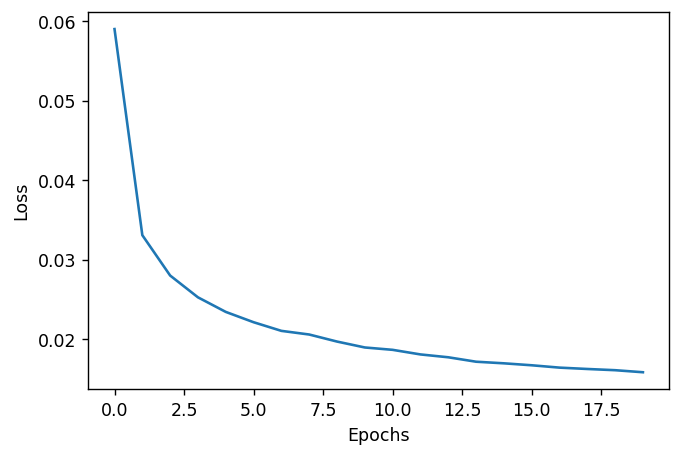

In [89]:
NN = NumpyNN(X_train, y_train) 
NN.train()
NN.plot()
NN.test(X_test,y_test)

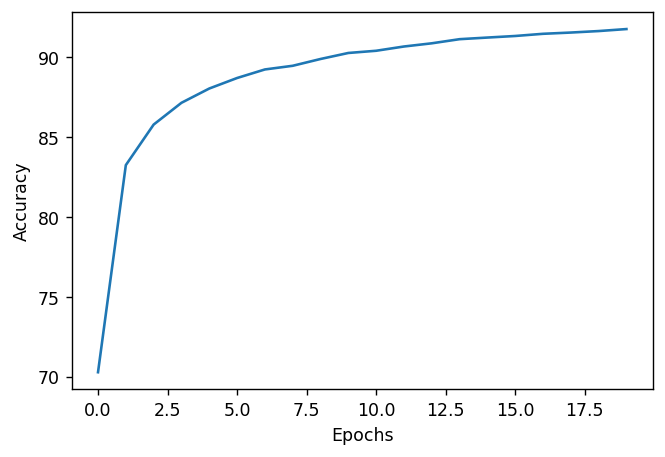

In [90]:
NN.acc_plot()

In [ ]:
#Batch size = 16, 90.93% accuracy, 2:05
#Batch size = 64, 90.4% accuracy, 1:14
#Batch size = 256, 87.7% accuracy, 0:40
#Batch size = 1024, 82.96% accuracy, 0:34

In [94]:
class AdamOptim():
    def __init__(self, eta=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.m_dw, self.v_dw = 0, 0
        self.m_db, self.v_db = 0, 0
        self.beta1 = beta1
        self.beta2 = beta2
        self.epochs = epochs
        self.epsilon = epsilon
        self.eta = eta
    def update(self, t, w, b, dw, db):
        ## dw, db are from current minibatch
        ## momentum beta 1
        # *** weights *** #
        self.m_dw = self.beta1*self.m_dw + (1-self.beta1)*dw
        # *** biases *** #
        self.m_db = self.beta1*self.m_db + (1-self.beta1)*db

        ## rms beta 2
        # *** weights *** #
        self.v_dw = self.beta2*self.v_dw + (1-self.beta2)*(dw**2)
        # *** biases *** #
        self.v_db = self.beta2*self.v_db + (1-self.beta2)*(db)

        ## bias correction
        m_dw_corr = self.m_dw/(1-self.beta1**t)
        m_db_corr = self.m_db/(1-self.beta1**t)
        v_dw_corr = self.v_dw/(1-self.beta2**t)
        v_db_corr = self.v_db/(1-self.beta2**t)

        ## update weights and biases
        w = w - self.eta*(m_dw_corr/(np.sqrt(v_dw_corr)+self.epsilon))
        b = b - self.eta*(m_db_corr/(np.sqrt(v_db_corr)+self.epsilon))
        return w, b

In [92]:
def loss_function(m):
    return m**2-2*m+1
## take derivative
def grad_function(m):
    return 2*m-2
def check_convergence(w0, w1):
    return (w0 == w1)

In [93]:
w_0 = 0
b_0 = 0
adam = AdamOptim()
t = 1 
converged = False

while not converged:
    dw = grad_function(w_0)
    db = grad_function(b_0)
    w_0_old = w_0
    w_0, b_0 = adam.update(t,w=w_0, b=b_0, dw=dw, db=db)
    if check_convergence(w_0, w_0_old):
        print('converged after '+str(t)+' iterations')
        break
    else:
        print('iteration '+str(t)+': weight='+str(w_0))
        t+=1

iteration 1: weight=0.009999999950000001
iteration 2: weight=0.01999725400385255
iteration 3: weight=0.029989900621600046
iteration 4: weight=0.039976060276935343
iteration 5: weight=0.049953839711732076
iteration 6: weight=0.05992133621693422
iteration 7: weight=0.06987664190678831
iteration 8: weight=0.07981784795404925
iteration 9: weight=0.08974304875491491
iteration 10: weight=0.0996503459940126
iteration 11: weight=0.10953785258172263
iteration 12: weight=0.11940369643843479
iteration 13: weight=0.12924602410293135
iteration 14: weight=0.13906300414491304
iteration 15: weight=0.14885283036466956
iteration 16: weight=0.15861372476597732
iteration 17: weight=0.1683439402914239
iteration 18: weight=0.17804176331244895
iteration 19: weight=0.1877055158694015
iteration 20: weight=0.19733355765979776
iteration 21: weight=0.2069242877756729
iteration 22: weight=0.21647614619342795
iteration 23: weight=0.22598761502184558
iteration 24: weight=0.23545721951596985
iteration 25: weight=0.24

/Users/cortthoreson/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in sqrt
